In [ ]:
import math
import numpy as np

D1 = 0.13987
L1 = 0.102
L2 = 0.107
L3 = 0.146
limb_angle = [45, 135, -135, -45]
def bound_range(angle):
    angle = angle%360
    angle = (angle + 360) % 360
    if (angle > 180):
        angle-=360
    return angle


def asin2(x):
  modu = math.asin(abs(x))
  if x > 0:
    return [modu, -modu + math.pi, 2 * math.pi + modu, - modu - math.pi]
  else:
    return [math.pi * 2 - modu, modu + math.pi, modu - math.pi, -modu]

def forward_kinematics(joint_angles, leg_num):
    ''' Returns the Forward Kinematics of the Limb

    Args:
        joint_angles: an array containing the joint angle value (in deg) at each joint
        leg_num: leg number between 1 to 4
    Returns:
        an array containing the x,y,z position (in m) of the limp tip in frame of reference of Base
    '''
    Th1, Th2, Th3 = joint_angles

    Th1 = math.radians(Th1)
    Th2 = math.radians(Th2)
    Th3 = math.radians(Th3)

    ### Forward Kinematics

    x = math.cos(Th1)* (L1 + L2*math.cos(Th2) + L3*math.cos(Th2+Th3))
    y = math.sin(Th1)* (L1 + L2*math.cos(Th2) + L3*math.cos(Th2+Th3))
    z = L2*math.sin(Th2) + L3*math.sin(Th2+Th3)

    '''
    Coordinate Transformation: Joint 1 to Base Frame
    '''
    theta = math.radians(limb_angle[leg_num-1])

    ### Rotation

    xb = x * math.cos(theta) - y * math.sin(theta)
    yb = x * math.sin(theta) + y * math.cos(theta)
    zb = z

    #### Translation ####
    xb = xb + D1 * math.cos(theta)
    yb = yb + D1 * math.sin(theta)

    return np.array([xb, yb, zb])

In [ ]:
# For checking if inverse kinematics works perfectly or not

initial_angles = [-np.pi/6, -np.pi/6, -np.pi/3]
position = forward_kinematics(initial_angles, 1)
print(position)
angles_again = inverse_kinematics(position, 1)
print(angles_again)
position_again = forward_kinematics(angles_again,1)
print(position_again)

[ 0.35216706  0.34757994 -0.00497998]
[-0.523598775598316, -1.7322264233232545, 1.0471975511986784]
[ 0.35216706  0.34757994 -0.00497998]


In [ ]:
import math
import numpy as np

def angleRange(angle):
  return angle - 2 * np.pi * ((angle + np.pi)//(2 * np.pi))


def jointAngles(position):
  '''
  Returns all possible inverse kinematics solution
  '''
  x, y, z = position
  solution_array = np.empty(shape=(0, 3), dtype='float64')
  angle_failed_array = np.empty(shape=(0, 3), dtype='float64')
  for angleJ1DoubleSolution in [-1, 1]:
    for angleJ3DoubleSolution in [-1,1]:
      angle_1_fail = False
      angle_2_fail = False
      angle_3_fail = False
      angle_3_fail_because_too_far = False
      a_j1 = np.arctan2(y, x) + np.pi * min(0, angleJ1DoubleSolution)
      if a_j1 > np.pi/2 or a_j1 < -np.pi/2:
        angle_1_fail = True
      r1 = angleJ1DoubleSolution * np.hypot(x, y) - L1
      valueCos = (r1**2 + z**2 - L2 **2 - L3 **2)/(2 * L2 * L3)
      if valueCos > 1:
        a_j3 = 0
        angle_3_fail = True
        angle_3_fail_because_too_far =  True
      elif valueCos < -1:
        angle_3_fail = True
        if angleJ3DoubleSolution == 1:
          a_j3 = np.pi/2 + np.pi/3
        else:
          a_j3 = -np.pi/2 - np.pi/3
      else:
        a_j3 = (angleJ3DoubleSolution * np.arccos(angleJ3DoubleSolution * valueCos) - np.pi * min(0, angleJ3DoubleSolution)) * angleJ3DoubleSolution
        a_j3 = angleRange(a_j3)

      if a_j3 > np.pi/2 + np.pi/3:
        angle_3_fail = True
        a_j3 = np.pi/2 + np.pi/3
      elif a_j3 < -np.pi/2 - np.pi/3:
        angle_3_fail = True
        a_j3 = -np.pi/2 - np.pi/3

      a_j2 = np.arctan2(z, r1) - np.arctan2(L3 * np.sin(a_j3), L2 + L3 * np.cos(a_j3))
      a_j2 = angleRange(a_j2)

      if not angle_3_fail_because_too_far:
        if a_j2 > np.pi/2:
          angle_2_fail = True
          a_j2 = np.pi/2
        elif a_j2 < -np.pi/2:
          angle_2_fail = True
          a_j2 = -np.pi/2
      else:
        if a_j2 > np.pi/2 or a_j2 < -np.pi/2:
          angle_2_fail = True
          if angleJ3DoubleSolution == 1:
            a_j2 = -np.pi/2
          else:
            a_j2 = np.pi/2
      if angle_2_fail:
        a_j3 = np.arctan2(z - L2 * np.sin(a_j2), x*np.cos(a_j1) + y * np.sin(a_j1) - L1 - L2 * np.cos(a_j2)) - a_j2
        a_j3 = angleRange(a_j3)

        if a_j3 > np.pi/2 + np.pi/3:
          angle_3_fail = True
          a_j3 = np.pi/2 + np.pi/3
        elif a_j3 < - np.pi/2 - np.pi/3:
          angle_3_fail = True
          a_j3 = -np.pi/2 - np.pi/3
      if angle_1_fail:
        if a_j1 > np.pi/2:
          a_j1 = np.pi/2
        elif a_j1 < -np.pi/2:
          a_j1 = -np.pi/2
      a_j3 = a_j3
      a_joints = np.array([[a_j1, a_j2, a_j3]], dtype='float64')
      a_failed = np.array([[angle_1_fail, angle_2_fail, angle_3_fail]], dtype='float64')
      solution_array = np.concatenate((solution_array, a_joints))
      angle_failed_array = np.concatenate((angle_failed_array, a_failed))
  return solution_array, angle_failed_array

def inverse_kinematics(position, leg_num):
    '''
    Does the coordinate transformation from body center to the limb
    '''

    xb, yb, zb = position

    '''
    Coordinate Transformation: Base to Joint 1 Frame
    '''
    theta = math.radians(limb_angle[leg_num-1])

    #### Translation ####
    xb = xb - D1 * math.cos(theta)
    yb = yb - D1 * math.sin(theta)


    ### Rotation

    x = xb * math.cos(theta) + yb * math.sin(theta)
    y = -xb * math.sin(theta) + yb * math.cos(theta)
    z = zb

    ### Inverse Kinematics
    solArray = jointAngles([x, y, z])
    return solArray

def IK_FINAL(most_recent_angle, target, legNum, threshold = 0):
  '''
  Find the best inverse kinematics solution based on the previous angles
  '''
  # Do IK here
  sol_array, angle_failed_array = inverse_kinematics(target, legNum)
  most_recent_angle = np.radians(np.array(most_recent_angle))
  num = 900000
  condition = 0  # none of the solutions satisfy the threshold
  angleFail = False
  for row in range(sol_array.shape[0]):
      xyz_difference = forward_kinematics(sol_array[row, :], legNum) - target
      dist_leg_target = np.linalg.norm(xyz_difference)
      if dist_leg_target <= threshold:
          criteria = abs(most_recent_angle[0] - sol_array[row, 0]) + abs(most_recent_angle[1] - sol_array[
              row, 1]) + abs(most_recent_angle[2] - sol_array[row, 2])
          condition = 1  # at least one solutions enters the threshold
          if criteria <= num:
              joint_angles = sol_array[row, :]
              angleFail =  np.any(angle_failed_array[row,:])
              num = criteria
  if condition == 0:
      for row in range(sol_array.shape[0]):
          criteria = abs(most_recent_angle[0] - sol_array[row, 0]) + abs(most_recent_angle[1] - sol_array[
              row, 1]) + abs(most_recent_angle[2] - sol_array[row, 2])
          if criteria <= num:
              joint_angles = sol_array[row, :]
              angleFail =  np.any(angle_failed_array[row,:])
              num = criteria

  if angleFail:
    raise Exception("Angles not within the range")
  else:
    return list(np.degrees(joint_angles))

In [ ]:
import matplotlib.pyplot as plt
def plotGraphs(com, end1, end2, end3, end4, lifted = 0):
  plt.plot(com[0], com[1], 'g+')
  plt.plot(end1[0], end1[1], 'ro')
  plt.annotate("1", (end1[0], end1[1]))
  plt.plot(end2[0], end2[1], 'ro')
  plt.annotate("2", (end2[0], end2[1]))
  plt.plot(end3[0], end3[1], 'ro')
  plt.annotate("3", (end3[0], end3[1]))
  plt.plot(end4[0], end4[1], 'ro')
  plt.annotate("4", (end4[0], end4[1]))
  if lifted == 1:
    plt.plot([end2[0], end3[0], end4[0], end2[0]], [end2[1], end3[1], end4[1], end2[1]])
    plt.plot(end1[0], end1[1], 'bo')
  elif lifted == 2:
    plt.plot([end1[0], end3[0], end4[0], end1[0]], [end1[1], end3[1], end4[1], end1[1]])
    plt.plot(end2[0], end2[1], 'bo')
  elif lifted == 3:
    plt.plot([end1[0], end2[0], end4[0], end1[0]], [end1[1], end2[1], end4[1], end1[1]])
    plt.plot(end3[0], end3[1], 'bo')
  elif lifted == 4:
    plt.plot([end1[0], end2[0], end3[0], end1[0]], [end1[1], end2[1], end3[1], end1[1]])
    plt.plot(end4[0], end4[1], 'bo')
  plt.show()

In [ ]:
#@title printROSDATA, function name getRosData(angle, dx, SM)

def getRosData(angle, dx, dz):
  print("HOME_POS1 =", angle)
  print("HOME_POS2 =", angle)
  print("HOME_POS3 =", angle)
  print("HOME_POS4 =", angle)

  position1 = forward_kinematics(angle, 1)
  position2 = forward_kinematics(angle, 2)
  position3 = forward_kinematics(angle, 3)
  position4 = forward_kinematics(angle, 4)

  position1[0] -= dx
  position2[0] -= dx
  position3[0] -= dx
  position4[0] -= dx

  try:
    angle1 = IK_FINAL(angle, position1, 1)
    print("STAGE11 =", angle1)
  except:
    print("No angle found for limb 1")

  try:
    angle2 =IK_FINAL(angle, position2, 2)
    print("STAGE12 =", angle2)
  except:
    print("No angle found for limb 2")

  try:
    angle3 = IK_FINAL(angle, position3, 3)
    print("STAGE13 =", angle3)
  except:
    print("No angle found for limb 3")
  try:
    angle4 = IK_FINAL(angle, position4, 4)
    print("STAGE14 =", angle4)
  except:
    print("No angle found for limb 4")


  position2[2] += dz
  try:
    angle2 = IK_FINAL(angle2, position2, 2)
    print("HOPI2 =", angle2)
  except:
    print("No angle found for limb 2")

  position2[0] += 3 * dx
  try:
    angle2 = IK_FINAL(angle2, position2, 2)
    print("HOPM2 =", angle2)
  except:
    print("No angle found for limb 2")

  position2[2] -= dz
  try:
    angle2 = IK_FINAL(angle2, position2, 2)
    print("HOPF2 =", angle2)
  except:
    print("No angle found for limb 2")

  position1[2] += dz
  try:
    angle1 = IK_FINAL(angle1, position1, 1)
    print("HOPI1 =", angle1)
  except:
    print("No angle found for limb 1")

  position1[0] += 3 * dx
  try:
    angle1 = IK_FINAL(angle1, position1, 1)
    print("HOPM1 =", angle1)
  except:
    print("No angle found for limb 2")

  position1[2] -= dz
  try:
    angle1 = IK_FINAL(angle1, position1, 1)
    print("HOPF1 =", angle1)
  except:
    print("No angle found for limb 1")


  position1[0] -= dx
  position2[0] -= dx
  position3[0] -= dx
  position4[0] -= dx

  try:
    angle1 = IK_FINAL(angle, position1, 1)
    print("STAGE21 =", angle1)
  except:
    print("No angle found for limb 1")

  try:
    angle2 =IK_FINAL(angle, position2, 2)
    print("STAGE22 =", angle2)
  except:
    print("No angle found for limb 2")

  try:
    angle3 = IK_FINAL(angle, position3, 3)
    print("STAGE23 =", angle3)
  except:
    print("No angle found for limb 3")
  try:
    angle4 = IK_FINAL(angle, position4, 4)
    print("STAGE24 =", angle4)
  except:
    print("No angle found for limb 4")

  position3[2] += dz
  try:
    angle3 = IK_FINAL(angle3, position3, 3)
    print("HOPI3 =", angle3)
  except:
    print("No angle found for limb 3")

  position3[0] += 3 * dx
  try:
    angle3 = IK_FINAL(angle3, position3, 3)
    print("HOPM3 =", angle3)
  except:
    print("No angle found for limb 3")

  position3[2] -= dz
  try:
    angle3 = IK_FINAL(angle3, position3, 3)
    print("HOPF3 =", angle3)
  except:
    print("No angle found for limb 3")

  position4[2] += dz
  try:
    angle4 = IK_FINAL(angle4, position4, 4)
    print("HOPI4 =", angle4)
  except:
    print("No angle found for limb 4")

  position4[0] += 3 * dx
  try:
    angle4 = IK_FINAL(angle4, position4, 4)
    print("HOPM4=", angle4)
  except:
    print("No angle found for limb 4")

  position4[2] -= dz
  try:
    angle4 = IK_FINAL(angle4, position4, 4)
    print("HOPF4 =", angle4)
  except:
    print("No angle found for limb 4")

  position1[0] -= 1 * dx
  position2[0] -= 1 * dx
  position3[0] -= 1 * dx
  position4[0] -= 1 * dx

  try:
    angle1 = IK_FINAL(angle, position1, 1)
    print("STAGE31 =", angle1)
  except:
    print("No angle found for limb 1")

  try:
    angle2 =IK_FINAL(angle, position2, 2)
    print("STAGE32 =", angle2)
  except:
    print("No angle found for limb 2")

  try:
    angle3 = IK_FINAL(angle, position3, 3)
    print("STAGE33 =", angle3)
  except:
    print("No angle found for limb 3")
  try:
    angle4 = IK_FINAL(angle, position4, 4)
    print("STAGE34 =", angle4)
  except:
    print("No angle found for limb 4")

In [ ]:
# Designing Gait Pattern
solnArray = []
for a2 in np.arange(-90, 90, 5):
  for a3 in np.arange(-120, 120, 5):
    for dx in np.arange(0.01, 0.2, 0.01):
      print(f"a2: {a2}, a3: {a3}, dx: {dx}", end='\r')
      angle = [0, a2, a3]
      dx = dx

      position1 = forward_kinematics(angle, 1)
      position2 = forward_kinematics(angle, 2)
      position3 = forward_kinematics(angle, 3)
      position4 = forward_kinematics(angle, 4)
      if position1[2] > -0.05:

        continue

      position1[0] -= dx
      position2[0] -= dx
      position3[0] -= dx
      position4[0] -= dx

      try:
        angle1 = IK_FINAL(angle, position1, 1)
      except:
        continue

      try:
        angle2 =IK_FINAL(angle, position2, 2)
      except:
        continue

      try:
        angle3 = IK_FINAL(angle, position3, 3)
      except:
        continue
      try:
        angle4 = IK_FINAL(angle, position4, 4)
      except:
        continue

      position2[0] += 3 * dx
      try:
        angle2 = IK_FINAL(angle2, position2, 2)
      except:
        continue

      position1[0] += 3 * dx

      try:
        angle1 = IK_FINAL(angle1, position1, 1)
      except:
        continue

      position1[0] -= dx
      position2[0] -= dx
      position3[0] -= dx
      position4[0] -= dx

      try:
        angle1 = IK_FINAL(angle1, position1, 1)
      except:
        continue

      try:
        angle2 =IK_FINAL(angle2, position2, 2)
      except:
        continue

      try:
        angle3 = IK_FINAL(angle3, position3, 3)
      except:
        continue
      try:
        angle4 = IK_FINAL(angle4, position4, 4)
      except:
        continue


      position3[0] += 3 * dx
      try:
        angle3 = IK_FINAL(angle3, position3, 3)
      except:
        continue

      position4[0] += 3 * dx
      try:
        angle4 = IK_FINAL(angle4, position4, 4)
      except:
        continue


      position1[0] -= 1 * dx
      position2[0] -= 1 * dx
      position3[0] -= 1 * dx
      position4[0] -= 1 * dx


      try:
        angle1 = IK_FINAL(angle1, position1, 1)
      except:
        continue

      try:
        angle2 =IK_FINAL(angle2, position2, 2)
      except:
        continue

      try:
        angle3 = IK_FINAL(angle3, position3, 3)
      except:
        continue
      try:
        angle4 = IK_FINAL(angle4, position4, 4)
      except:
        continue
      solnArray.append([a2, a3, dx, position1[2]])

In [ ]:
# solnArray = sorted(solnArray, key = lambda x: x[2], reverse =True)
for i in solnArray:
  print(i)

[5, -115, 0.09, -0.1278694581607432]
[10, -120, 0.09, -0.11861476762438108]
[15, -120, 0.09, -0.11333153281223425]
[20, -120, 0.09, -0.10718577660393581]
[-5, -105, 0.08, -0.14652078710874206]
[0, -115, 0.08, -0.1323209369073509]
[0, -110, 0.08, -0.13719512263474262]
[0, -105, 0.08, -0.14102517063820397]
[5, -120, 0.08, -0.12299527243335147]
[5, -115, 0.08, -0.1278694581607432]
[5, -110, 0.08, -0.13169950616420453]
[10, -120, 0.08, -0.11861476762438108]
[10, -115, 0.08, -0.12244481562784243]
[10, -110, 0.08, -0.12520157692942083]
[15, -120, 0.08, -0.11333153281223425]
[15, -115, 0.08, -0.11608829411381265]
[20, -120, 0.08, -0.10718577660393581]
[20, -115, 0.08, -0.10884827058554829]
[25, -120, 0.08, -0.10022427191514]
[25, -115, 0.08, -0.10077984599374515]
[30, -120, 0.08, -0.0925]
[35, -120, 0.08, -0.08407174723183292]
[40, -120, 0.08, -0.07500365770332267]
[-15, -95, 0.06999999999999999, -0.16488876046071235]
[-15, -90, 0.06999999999999999, -0.1687188084641737]
[-10, -105, 0.06999999

Text(0, 0.5, 'Safety Margin (in m)')

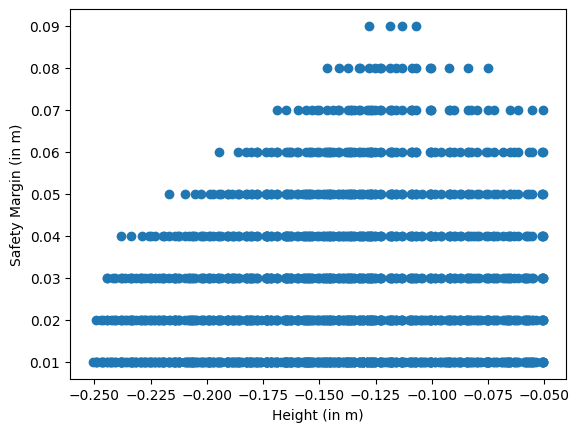

In [ ]:
plt.scatter([i[3] for i in solnArray], [i[2] for i in solnArray])
plt.xlabel('Height (in m)')
plt.ylabel('Safety Margin (in m)')

In [ ]:
for i in solnArray:
  angle = [0.0,i[0], i[1]]
  homeAngle = angle
  dx = i[2]
  # DY = 0.05

  position1 = forward_kinematics(angle, 1)
  position2 = forward_kinematics(angle, 2)
  position3 = forward_kinematics(angle, 3)
  position4 = forward_kinematics(angle, 4)

  z = position1[2]

  position1[2] = 0
  position2[2] = 0
  position3[2] = 0
  position4[2] = 0

  try:
    angle1 = IK_FINAL(angle, position1, 1)
  except:
    continue

  try:
    angle2 =IK_FINAL(angle, position2, 2)
  except:
    continue

  try:
    angle3 = IK_FINAL(angle, position3, 3)
  except:
    continue
  try:
    angle4 = IK_FINAL(angle, position4, 4)
  except:
    continue
  print(i)


[35, -120, 0.08, -0.08407174723183292]
[40, -120, 0.08, -0.07500365770332267]
[15, -105, 0.06999999999999999, -0.11830636217403027]
[20, -110, 0.06999999999999999, -0.10940384466415344]
[20, -105, 0.06999999999999999, -0.10884827058554829]
[25, -110, 0.06999999999999999, -0.10022427191514]
[30, -115, 0.06999999999999999, -0.09194442592139485]
[30, -110, 0.06999999999999999, -0.09028193193978237]
[35, -120, 0.06999999999999999, -0.08407174723183292]
[35, -115, 0.06999999999999999, -0.08240925325022044]
[35, -110, 0.06999999999999999, -0.07965249194864205]
[40, -120, 0.06999999999999999, -0.07500365770332267]
[40, -115, 0.06999999999999999, -0.07224689640174424]
[45, -120, 0.06999999999999999, -0.06536474505124336]
[45, -115, 0.06999999999999999, -0.061534697047782014]
[50, -120, 0.06999999999999999, -0.055228367221011945]
[50, -115, 0.06999999999999999, -0.05035418149362024]
[0, -90, 0.060000000000000005, -0.146]
[5, -95, 0.060000000000000005, -0.13667433552600056]
[10, -100, 0.06000000

[ 0.24212546  0.24212546 -0.18259616]
Limb 1: [3.925697427630646e-15, 89.35366664270141, -136.47784417337633]
Limb 2: [3.925697427630646e-15, 89.35366664270141, -136.47784417337633]
Limb 3: [-3.925697427630646e-15, 89.35366664270141, -136.47784417337633]
Limb 4: [-3.925697427630646e-15, 89.35366664270141, -136.47784417337633]
Limb 1: [3.925697427630646e-15, -20.00000000000001, -70.0]
Limb 2: [3.925697427630646e-15, -20.00000000000001, -70.0]
Limb 3: [-3.925697427630646e-15, -20.00000000000001, -70.0]
Limb 4: [-3.925697427630646e-15, -20.00000000000001, -70.0]
Limb 1: [9.219174021856327, -21.251769704898795, -78.67958123792823]
Limb 2: [6.985753688120342, -21.948428666936277, -55.66695052776183]
Limb 3: [-6.985753688120342, -21.948428666936277, -55.66695052776183]
Limb 4: [-9.219174021856327, -21.251769704898795, -78.67958123792823]


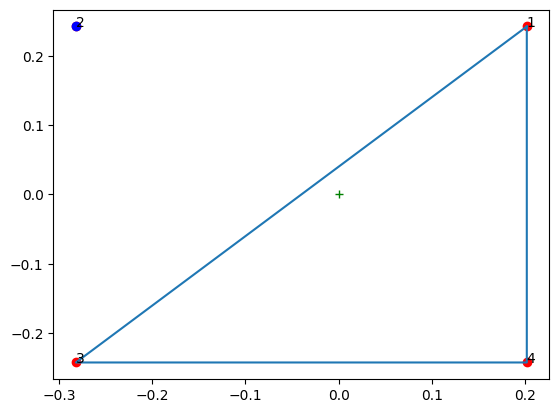

Limb 2: [-21.18197993631205, -23.799665823247313, -83.47087738025344]


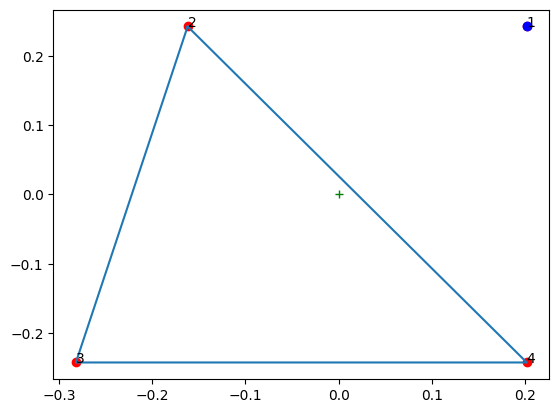

Limb 1: [-12.315238152148359, -31.183699848277, -29.413173725694342]
Limb 1: [-6.985753688120338, -21.948428666936277, -55.66695052776183]
Limb 2: [-9.21917402185632, -21.251769704898802, -78.67958123792823]
Limb 3: [-12.315238152148364, -31.183699848276987, -29.413173725694392]
Limb 4: [-21.181979936312057, -23.7996658232473, -83.47087738025344]


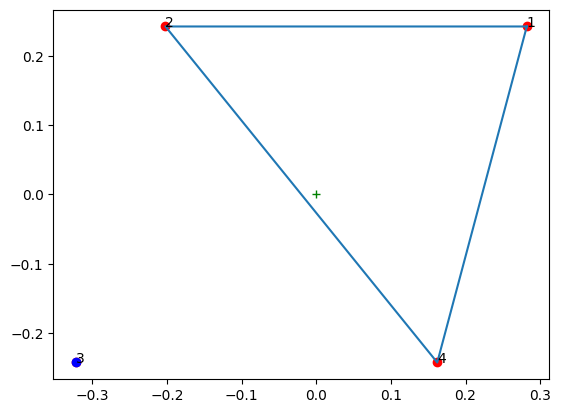

Limb 3: [9.219174021856324, -21.251769704898802, -78.67958123792823]


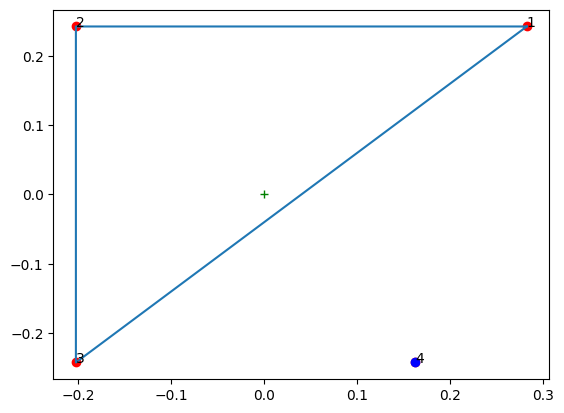

Limb 4: [6.985753688120326, -21.948428666936277, -55.666950527761855]


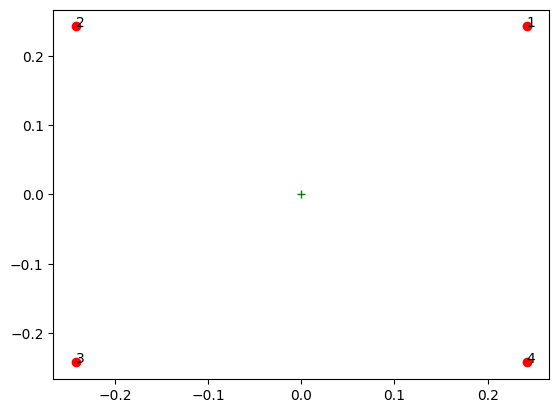

Limb 1: [-3.925697427630646e-15, -20.000000000000004, -69.99999999999999]
Limb 2: [7.851394855261293e-15, -20.00000000000001, -70.0]
Limb 3: [-3.925697427630646e-15, -20.00000000000001, -70.0]
Limb 4: [-3.925697427630646e-15, -20.00000000000001, -70.0]


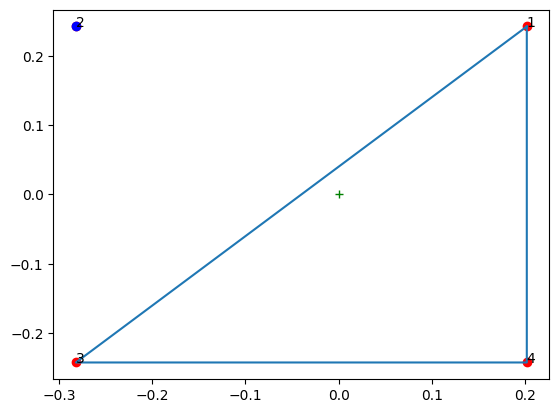

Limb 1: [9.219174021856324, -21.251769704898802, -78.67958123792823]
Limb 2: [6.985753688120342, -21.948428666936277, -55.66695052776183]
Limb 3: [-6.985753688120342, -21.948428666936277, -55.66695052776183]
Limb 4: [-9.219174021856338, -21.251769704898802, -78.67958123792823]


In [ ]:
# Designing Gait Pattern
angle = [0.0,-20.0, -70.0]
homeAngle = angle
dx = 0.04
# DY = 0.05

position1 = forward_kinematics(angle, 1)
print(position1)
position2 = forward_kinematics(angle, 2)
position3 = forward_kinematics(angle, 3)
position4 = forward_kinematics(angle, 4)

z = position1[2]

position1[2] = 0
position2[2] = 0
position3[2] = 0
position4[2] = 0

try:
  angle1 = IK_FINAL(angle, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

try:
  angle2 =IK_FINAL(angle, position2, 2)
  print("Limb 2:", angle2)
except:
  print("No angle found for limb 2")

try:
  angle3 = IK_FINAL(angle, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")
try:
  angle4 = IK_FINAL(angle, position4, 4)
  print("Limb 4:", angle4)
except:
  print("No angle found for limb 4")

position1[2] = z
position2[2] = z
position3[2] = z
position4[2] = z

try:
  angle1 = IK_FINAL(angle, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

try:
  angle2 =IK_FINAL(angle, position2, 2)
  print("Limb 2:", angle2)
except:
  print("No angle found for limb 2")

try:
  angle3 = IK_FINAL(angle, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")
try:
  angle4 = IK_FINAL(angle, position4, 4)
  print("Limb 4:", angle4)
except:
  print("No angle found for limb 4")

position1[0] -= dx
position2[0] -= dx
position3[0] -= dx
position4[0] -= dx
angle1 = IK_FINAL(angle, position1, 1)

try:
  angle1 = IK_FINAL(angle, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

try:
  angle2 =IK_FINAL(angle, position2, 2)
  print("Limb 2:", angle2)
except:
  print("No angle found for limb 2")

try:
  angle3 = IK_FINAL(angle, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")
try:
  angle4 = IK_FINAL(angle, position4, 4)
  print("Limb 4:", angle4)
except:
  print("No angle found for limb 4")

plotGraphs([0,0,0], position1, position2, position3, position4, 2)

position2[0] += 3 * dx
try:
  angle2 = IK_FINAL(angle2, position2, 2)
  print("Limb 2:", angle2)
except:
  print("No angle found for limb 2")

plotGraphs([0,0,0], position1, position2, position3, position4, 1)

position1[0] += 3 * dx

try:
  angle1 = IK_FINAL(angle1, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

position1[0] -= dx
position2[0] -= dx
position3[0] -= dx
position4[0] -= dx

try:
  angle1 = IK_FINAL(angle1, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

try:
  angle2 =IK_FINAL(angle2, position2, 2)
  print("Limb 2:", angle2)
except:
  print("No angle found for limb 2")

try:
  angle3 = IK_FINAL(angle3, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")
try:
  angle4 = IK_FINAL(angle4, position4, 4)
  print("Limb 4:", angle4)
except:
  print("No angle found for limb 4")



plotGraphs([0,0,0], position1, position2, position3, position4, 3)


position3[0] += 3 * dx
try:
  angle3 = IK_FINAL(angle3, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")

plotGraphs([0,0,0], position1, position2, position3, position4, 4)

position4[0] += 3 * dx
try:
  angle4 = IK_FINAL(angle4, position4, 4)
  print("Limb 4:", angle4)
except:
  print("No angle found for limb 4")

# plotGraphs([0,0,0], position1, position2, position3, position4)

position1[0] -= 1 * dx
position2[0] -= 1 * dx
position3[0] -= 1 * dx
position4[0] -= 1 * dx


plotGraphs([0,0,0], position1, position2, position3, position4)
try:
  angle1 = IK_FINAL(angle1, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

try:
  angle2 =IK_FINAL(angle2, position2, 2)
  print("Limb 2:", angle2)
except:
  print("No angle found for limb 2")

try:
  angle3 = IK_FINAL(angle3, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")
try:
  angle4 = IK_FINAL(angle4, position4, 4)
  print("Limb 4:", angle4)
except:
  print("No angle found for limb 4")


position1[0] -= 1 * dx
position2[0] -= 1 * dx
position3[0] -= 1 * dx
position4[0] -= 1 * dx

plotGraphs([0,0,0], position1, position2, position3, position4, 2)
try:
  angle1 = IK_FINAL(angle1, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

try:
  angle2 =IK_FINAL(angle2, position2, 2)
  print("Limb 2:", angle2)
except:
  print("No angle found for limb 2")

try:
  angle3 = IK_FINAL(angle3, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")
try:
  angle4 = IK_FINAL(angle4, position4, 4)
  print("Limb 4:", angle4)
except:
  print("No angle found for limb 4")


In [ ]:
getRosData([homeAngle[0], homeAngle[1], homeAngle[2]], dx, dz = 0.05)

HOME_POS1 = [0.0, -20.0, -70.0]
HOME_POS2 = [0.0, -20.0, -70.0]
HOME_POS3 = [0.0, -20.0, -70.0]
HOME_POS4 = [0.0, -20.0, -70.0]
STAGE11 = [9.219174021856327, -21.251769704898795, -78.67958123792823]
STAGE12 = [6.985753688120342, -21.948428666936277, -55.66695052776183]
STAGE13 = [-6.985753688120342, -21.948428666936277, -55.66695052776183]
STAGE14 = [-9.219174021856327, -21.251769704898795, -78.67958123792823]
HOPI2 = [6.985753688120342, 6.110640040901991, -86.58326578097487]
HOPM2 = [-21.18197993631205, 1.9730445449746918, -112.99783373585535]
HOPF2 = [-21.18197993631205, -23.799665823247313, -83.47087738025344]
HOPI1 = [9.219174021856327, 5.283718247501729, -107.94530361839895]
HOPM1 = [-12.315238152148359, 1.144468843538323, -68.48798217271339]
HOPF1 = [-12.315238152148359, -31.183699848277, -29.413173725694342]
STAGE21 = [-6.985753688120338, -21.948428666936277, -55.66695052776183]
STAGE22 = [-9.21917402185632, -21.251769704898802, -78.67958123792823]
STAGE23 = [-12.315238152148364

### Make the moonbot dance

In [ ]:
# Designing Gait Pattern
angle = [0.0,-45.0, -45.0]
homeAngle = angle
ds = 0.08
dy = 0.08
dz = 0.07
# DY = 0.05

position1 = forward_kinematics(angle, 1)
print(position1)
position2 = forward_kinematics(angle, 2)
position3 = forward_kinematics(angle, 3)
position4 = forward_kinematics(angle, 4)
print("Let's make the bot stable")
position1[1] -= ds * 0.707
position1[0] += ds * 0.707
position2[1] -= ds * 0.707
position2[0] += ds * 0.707
position3[1] -= ds * 0.707
position3[0] += ds * 0.707

try:
  angle1 = IK_FINAL(angle, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

try:
  angle2 =IK_FINAL(angle, position2, 2)
  print("Limb 2:", angle2)
except:
  print("No angle found for limb 2")

try:
  angle3 = IK_FINAL(angle, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")
try:
  angle4 = IK_FINAL(angle, position4, 4)
  print("Limb 4:", angle4)
except:
  print("No angle found for limb 4")

print("Step 1")
position1[1] += dy * 0.707
position1[0] += dy * 0.707
position1[2] += dz
position2[1] += dy * 0.707
position2[0] += dy * 0.707
position2[2] += dz
position3[1] += dy * 0.707
position3[0] += dy * 0.707
position3[2] += dz

try:
  angle1 = IK_FINAL(angle, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

try:
  angle2 =IK_FINAL(angle, position2, 2)
  print("Limb 2:", angle2)
except:
  print("No angle found for limb 2")

try:
  angle3 = IK_FINAL(angle, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")
try:
  angle4 = IK_FINAL(angle, position4, 4)
  print("Limb 4:", angle4)
except:
  print("No angle found for limb 4")

position1[1] -= dy * 0.707
position1[0] -= dy * 0.707
position1[2] -= dz
position2[1] -= dy * 0.707
position2[0] -= dy * 0.707
position2[2] -= dz
position3[1] -= dy * 0.707
position3[0] -= dy * 0.707
position3[2] -= dz

try:
  angle1 = IK_FINAL(angle, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

try:
  angle2 =IK_FINAL(angle, position2, 2)
  print("Limb 2:", angle2)
except:
  print("No angle found for limb 2")

try:
  angle3 = IK_FINAL(angle, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")
try:
  angle4 = IK_FINAL(angle, position4, 4)
  print("Limb 4:", angle4)
except:
  print("No angle found for limb 4")

print("Step 2")
position1[1] -= dy * 0.707
position1[0] -= dy * 0.707
position1[2] += dz
position2[1] -= dy * 0.707
position2[0] -= dy * 0.707
position2[2] += dz
position3[1] -= dy * 0.707
position3[0] -= dy * 0.707
position3[2] += dz

try:
  angle1 = IK_FINAL(angle, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

try:
  angle2 =IK_FINAL(angle, position2, 2)
  print("Limb 2:", angle2)
except:
  print("No angle found for limb 2")

try:
  angle3 = IK_FINAL(angle, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")
try:
  angle4 = IK_FINAL(angle, position4, 4)
  print("Limb 4:", angle4)
except:
  print("No angle found for limb 4")

position1[1] += dy * 0.707
position1[0] += dy * 0.707
position1[2] -= dz
position2[1] += dy * 0.707
position2[0] += dy * 0.707
position2[2] -= dz
position3[1] += dy * 0.707
position3[0] += dy * 0.707
position3[2] -= dz

try:
  angle1 = IK_FINAL(angle, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

try:
  angle2 =IK_FINAL(angle, position2, 2)
  print("Limb 2:", angle2)
except:
  print("No angle found for limb 2")

try:
  angle3 = IK_FINAL(angle, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")
try:
  angle4 = IK_FINAL(angle, position4, 4)
  print("Limb 4:", angle4)
except:
  print("No angle found for limb 4")

print("Step 3")

position1[2] += dz
position2[2] += dz
position3[2] += dz

try:
  angle1 = IK_FINAL(angle, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

try:
  angle2 =IK_FINAL(angle, position2, 2)
  print("Limb 2:", angle2)
except:
  print("No angle found for limb 2")

try:
  angle3 = IK_FINAL(angle, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")
try:
  angle4 = IK_FINAL(angle, position4, 4)
  print("Limb 4:", angle4)
except:
  print("No angle found for limb 4")


[ 0.22452792  0.22452792 -0.22166043]
Let's make the bot stable
Limb 1: [-24.2386672162116, -45.8837962702258, -36.895027687569026]
Limb 2: [0.0, -57.01472234956069, -58.36628600432607]
Limb 3: [24.2386672162116, -45.8837962702258, -36.895027687569026]
Limb 4: [-4.4756093977534546e-15, -45.000000000000014, -44.99999999999997]
Step 1
Limb 1: [-17.2471566778746, -10.648678589737687, -53.9525376745023]
Limb 2: [-39.31541736722683, -15.59310388167822, -107.07940210856202]
Limb 3: [39.31541736722683, -15.59310388167822, -107.07940210856202]
Limb 4: [-4.4756093977534546e-15, -45.000000000000014, -44.99999999999997]
Limb 1: [-24.2386672162116, -45.8837962702258, -36.895027687569026]
Limb 2: [0.0, -57.01472234956069, -58.36628600432607]
Limb 3: [24.2386672162116, -45.8837962702258, -36.895027687569026]
Limb 4: [-4.4756093977534546e-15, -45.000000000000014, -44.99999999999997]
Step 2
Limb 1: [-39.31541736722683, -15.59310388167822, -107.07940210856202]
Limb 2: [39.31541736722683, -15.5931038816

In [ ]:
angle = [0.0, 64.0, -130.0]
position1 = forward_kinematics(angle, 1)
position3 = forward_kinematics(angle, 3)
dx = 0.15
position1[2] -= 0.1
position3[2] -= 0.1

try:
  angle1 = IK_FINAL(angle, position1, 1)
  print("Limb 1:", angle1)
except:
  print("No angle found for limb 1")

try:
  angle3 = IK_FINAL(angle, position3, 3)
  print("Limb 3:", angle3)
except:
  print("No angle found for limb 3")

Limb 1: [7.634946328558993e-15, 4.713694881203355, -94.8505923481261]
Limb 3: [-7.634946328558993e-15, 4.713694881203355, -94.8505923481261]
